In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
spark = (
    SparkSession.builder.appName("analyzing")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/08/25 10:06:59 WARN Utils: Your hostname, MinhVu resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/08/25 10:06:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/25 10:07:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.parquet('../data/curated/test_pred')

#### RMSE after exponential transformation

In [39]:
df2 = df.select('base_passenger_fare', 'trip_miles', 'pred_gbt', 'pred_lm')

In [42]:
# Mean of base_passenger_fare
df2.agg(F.avg('base_passenger_fare')).collect()[0][0]

24.76117943621387

In [40]:
# Take the exp
df2 = df2.withColumn('exp_gbt', F.exp('pred_gbt'))
df2 = df2.withColumn('exp_lm', F.exp('pred_lm'))

In [41]:
# RMSE after exp transformation
evaluator_gbt = RegressionEvaluator(
    labelCol="base_passenger_fare",
    predictionCol="exp_gbt",
    metricName="rmse"
)

evaluator_lm = RegressionEvaluator(
    labelCol="base_passenger_fare",
    predictionCol="exp_lm",
    metricName="rmse"
)

# Calculate RMSE
rmse_gbt = evaluator_gbt.evaluate(df2)
rmse_lm = evaluator_lm.evaluate(df2)

print(f'RMSE LR: {rmse_lm}')
print(f'RMSE GBT: {rmse_gbt}')

RMSE LR: 9.394214149680618
RMSE GBT: 8.710120699107748


#### High vs Low Demand Area - avg(base_passenger_fare)

In [53]:
df3 = df.groupBy('pulocationid').agg(
    F.mean('base_passenger_fare').alias('avg_fare'),
    F.mean(F.exp('pred_gbt')).alias('avg_pred_fare')
    F.count('pulocationid').alias('demand')
).orderBy('demand', ascending=False)
df3 = df3.toPandas()

In [59]:
df3.head(5)

,pulocationid,avg_fare,avg_pred_fare,demand
0,138,49.620582,42.405130,275729
1,132,58.626892,53.271606,235872
2,61,20.349514,21.274120,189048
3,79,24.935632,23.154569,187460
4,161,33.339333,26.926597,176762


In [58]:
df3.tail(2)

,pulocationid,avg_fare,avg_pred_fare,demand
256,110,22.896750,23.709278,40
257,2,29.559444,27.371754,36


#### Surge Multiplier

In [64]:
# This has high demand + low error -> choose this to consider surge multiplier
zones = pd.read_csv('../data/taxi_zones/zone_lookup.csv')
zones[zones['LocationID'] == 61]

,Unnamed: 0,LocationID,Borough,Zone,service_zone
60,60,61,Brooklyn,Crown Heights North,Boro Zone


Find the lowest-demand hour

In [27]:
df4 = df.select('date', 'hour', 'base_passenger_fare', 'pred_gbt', 'trip_miles').filter(F.col('pulocationid') == 61)

In [28]:
df5 = df4.groupBy('hour').agg(
    F.count('hour').alias('demand')
).orderBy('hour').toPandas()

In [30]:
df5.sort_values(by='demand').head(5)

,hour,demand
3,3,2490
4,4,2513
2,2,3124
5,5,3217
1,1,4810


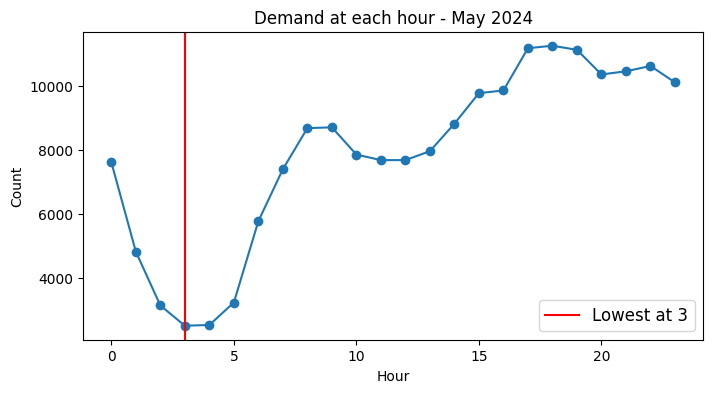

In [80]:
# Plotting
plt.figure(figsize=(8, 4))

plt.plot(df5['hour'], df5['demand'], marker='o')
plt.axvline(x=3, label='Lowest at 3', color='red')


plt.title('Demand at each hour - May 2024')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.legend(loc='lower right', fontsize=12)
plt.savefig('../plots/demand_hour.png')

Estimating surge multiplier

In [40]:
# Dataframe for date and standard fare
df6 = df4.filter(F.col('hour') == 3).groupBy('date').agg(
    F.mean(F.col('base_passenger_fare')/F.col('trip_miles')).alias('actual_standard_FPM'),
    F.mean(F.exp('pred_gbt')/F.col('trip_miles')).alias('pred_standard_FPM')
).orderBy('date').toPandas()
df6['date'] = pd.to_datetime(df6['date'])

df6.head()

,date,actual_standard_FPM,pred_standard_FPM
0,2024-05-01,5.889283,6.503551
1,2024-05-02,5.643340,6.215390
2,2024-05-03,5.347645,6.084559
3,2024-05-04,5.951577,6.548302
4,2024-05-05,6.095225,6.733179


In [41]:
# Dataframe for avg fare at each hour 
df7 = df4.groupBy('date', 'hour').agg(
    F.mean(F.col('base_passenger_fare')/F.col('trip_miles')).alias('actual_surge_avg_FPM'),
    F.mean(F.exp('pred_gbt')/F.col('trip_miles')).alias('pred_surge_avg_FPM')
).orderBy('date', 'hour').toPandas()

df7['date'] = pd.to_datetime(df7['date'])

# It has data from 2024-04-30 23pm but miss 2024-05-01 22pm so I change it
df7.loc[0, 'date'] = '2024-05-01'
df7.loc[0, 'hour'] = 22
df7 = df7.sort_values(by=['date', 'hour'])

In [42]:
df_final = pd.merge(df6, df7, on='date', how='inner')

In [43]:
# Create surge multiplier (actual and pred) columns
df_final['actual_multiplier'] = df_final['actual_surge_avg_FPM']/df_final['actual_standard_FPM']
df_final['pred_multiplier'] = df_final['pred_surge_avg_FPM']/df_final['pred_standard_FPM']

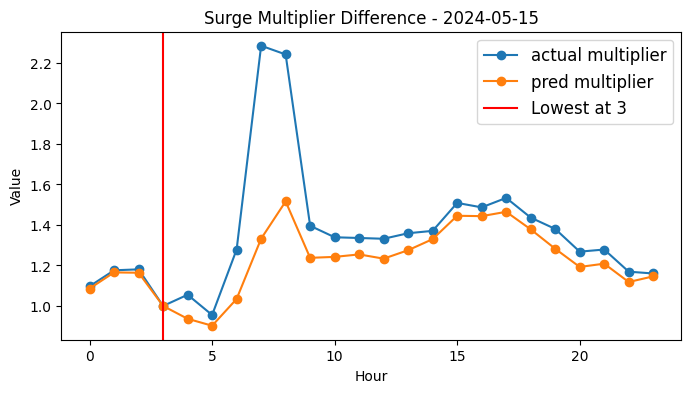

In [44]:
# Plot the actual vs pred surge multiplier difference in a random day
df_chosen = df_final[df_final['date'] == '2024-05-15']

plt.figure(figsize=(8, 4))
plt.plot(df_chosen['hour'], df_chosen['actual_multiplier'], label='actual multiplier', marker='o')
plt.plot(df_chosen['hour'], df_chosen['pred_multiplier'], label='pred multiplier', marker='o')
plt.axvline(x=3, label='Lowest at 3', color='red')


plt.title('Surge Multiplier Difference - 2024-05-15')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.legend(fontsize=12)

plt.savefig('../plots/surge_diff.png')

In [45]:
# RMSE
df_final = spark.createDataFrame(df_final)

evaluator_surge = RegressionEvaluator(
    labelCol="actual_multiplier",
    predictionCol="pred_multiplier",
    metricName="rmse"
)

rmse_surge = evaluator_surge.evaluate(df_final)

print(f'RMSE: {rmse_surge}')

RMSE: 0.09850541319794555
